### Student Details

### Student Name: Aidan Keeshan
### Student ID: 18200117

You may add two extra libraries: one to make a train-test split and one to perform a grid search

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
import math

Sample code to plot SVM margin, 'gutters' and support vectors

In [2]:
def plot_bound(X_train,y_train,clf,title):
    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, cmap=plt.cm.Paired)
    plt.title(title)
    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    
    Z = clf.best_estimator_.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.best_estimator_.support_vectors_[:, 0], clf.best_estimator_.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

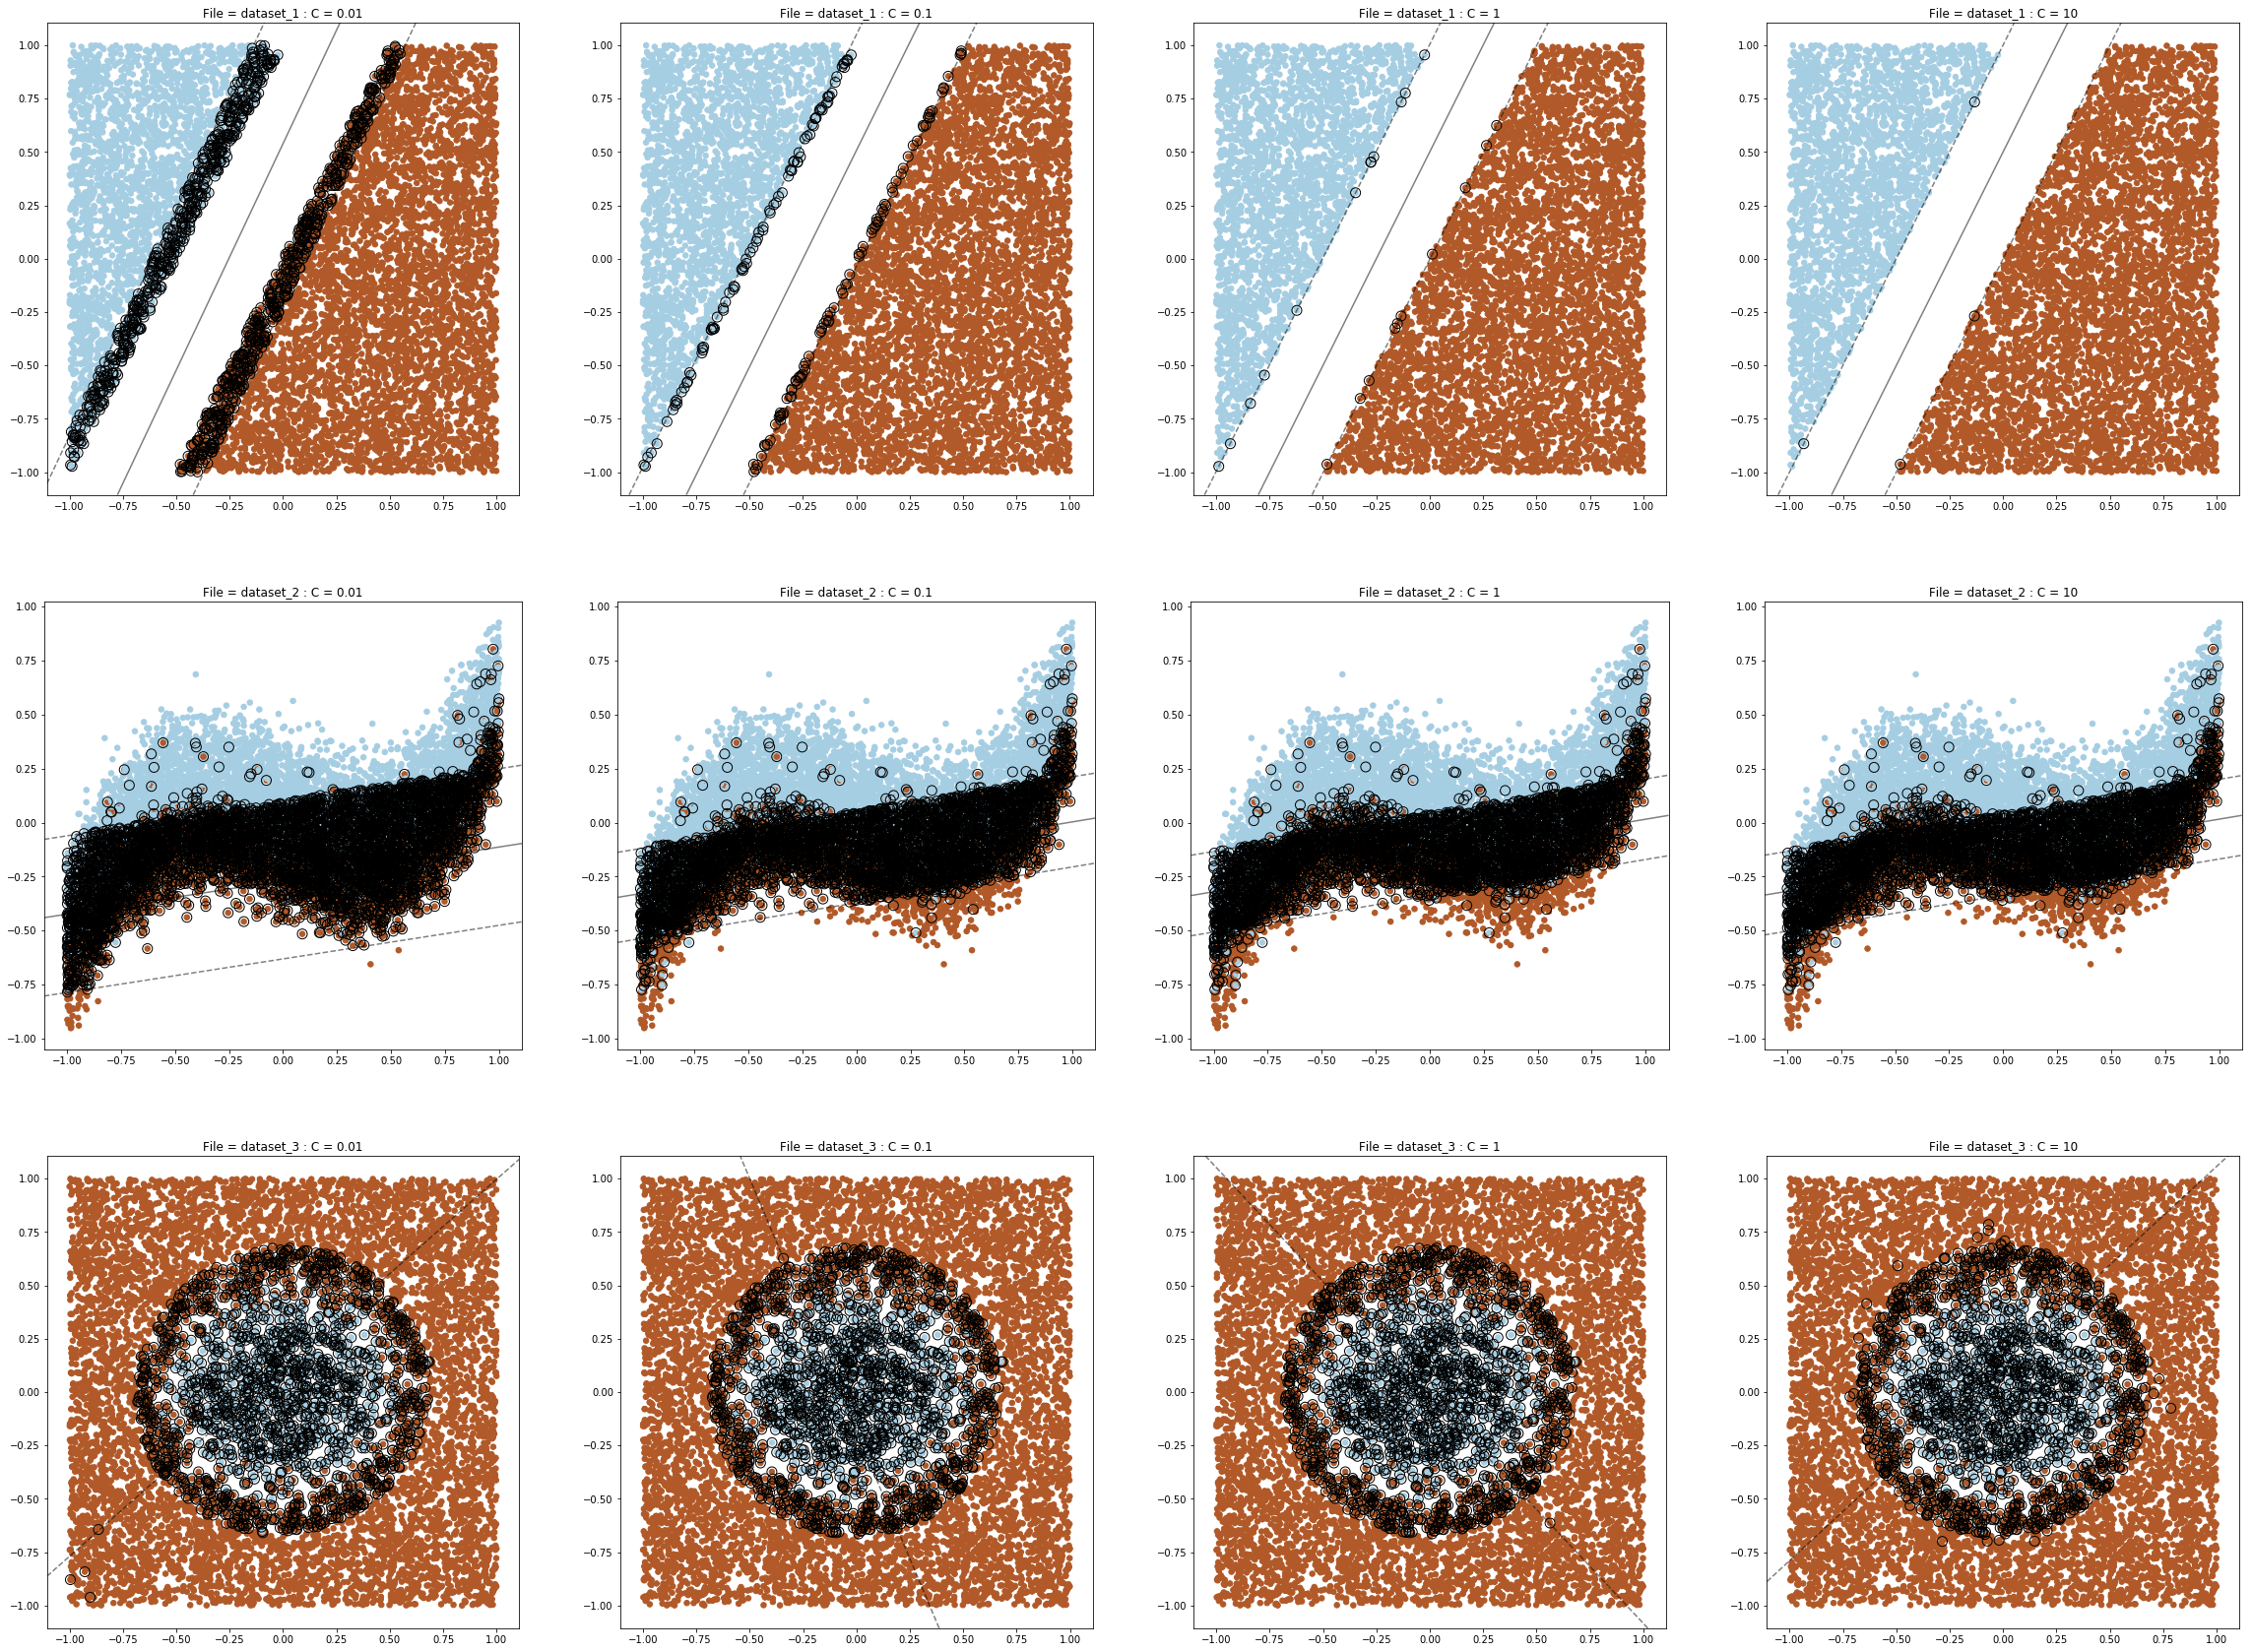

In [3]:
from sklearn.model_selection import train_test_split
from dask_searchcv import GridSearchCV

def import_csv(src_csv):
    ds = np.genfromtxt(src_csv, delimiter=',',skip_header=1,dtype=[('index','u4'),('VAR1','f8'),('VAR2','f8'),('TARGET','u1')])
    return train_test_split(np.c_[ds['VAR1'],ds['VAR2']], ds['TARGET'], test_size=0.2, random_state=0)

data = {}

for csv_n in [1,2,3]:
    key = 'dataset_'+str(csv_n)
    data[key] = import_csv(key+'.csv')

i = 1
f = plt.figure(figsize=(40,30))

for key in data:
    for c in [0.01,0.1,1,10]:
        GS = GridSearchCV(svm.SVC(), {'kernel':['linear'],'C': [c]},cv=3,n_jobs=-1)
        clf = GS.fit(data[key][0],data[key][2])
        ax = f.add_subplot(3,4,i)
        plot_bound(data[key][0],data[key][2],clf,'File = {} : C = {}'.format(key,c))
        i += 1

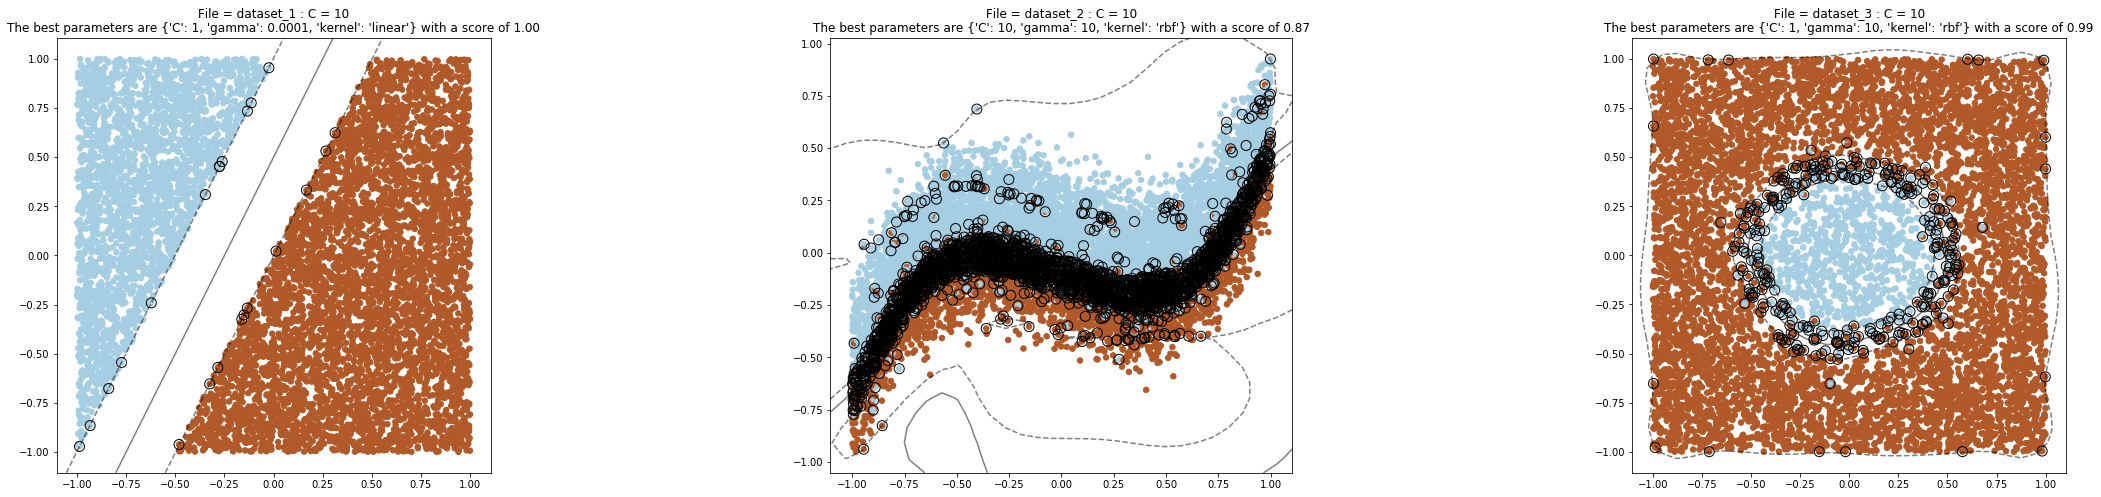

In [8]:
i = 1
f = plt.figure(figsize=(40,8))
GS_results = []
for key in data:
    GS = GridSearchCV(svm.SVC(),{'kernel': ['linear','rbf','sigmoid'],'C': [1,3,10,33,100], 'gamma': [0.0001, 0.001,0.01,1,10]},cv=10,return_train_score=True)
    clf = GS.fit(data[key][0],data[key][2])
    GS_results.append(GS.cv_results_)
    ax = f.add_subplot(1,3,i)
    plot_bound(data[key][0],data[key][2],clf,'File = {} : C = {}\nThe best parameters are {} with a score of {:.2f}'.format(key,c,GS.best_params_, GS.best_score_))
    i += 1

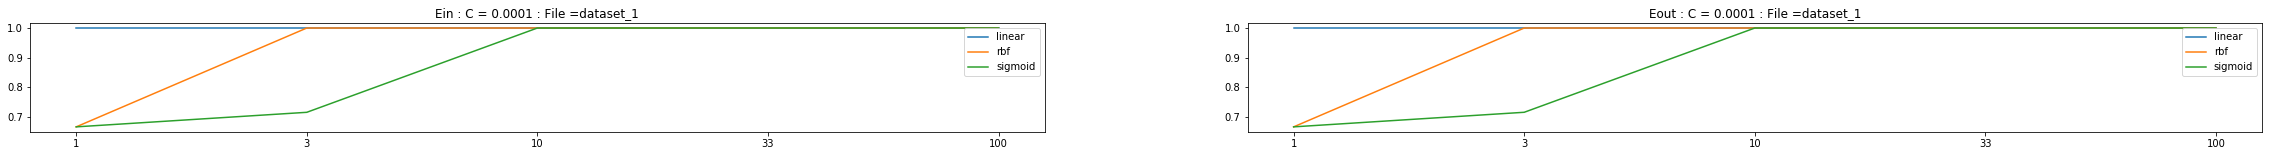

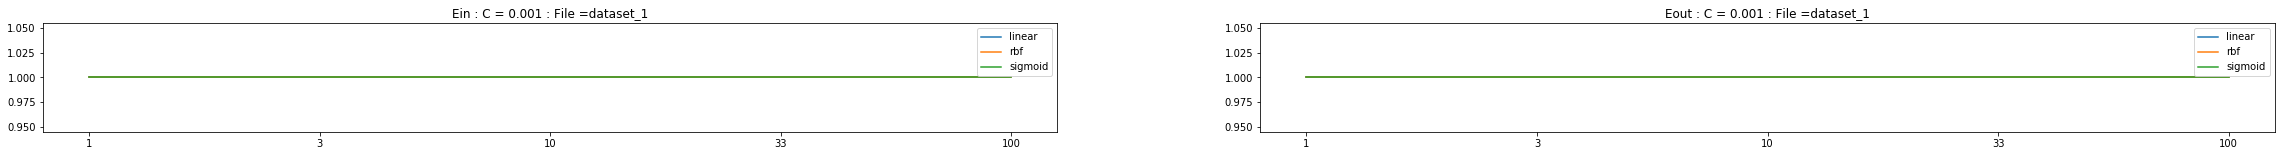

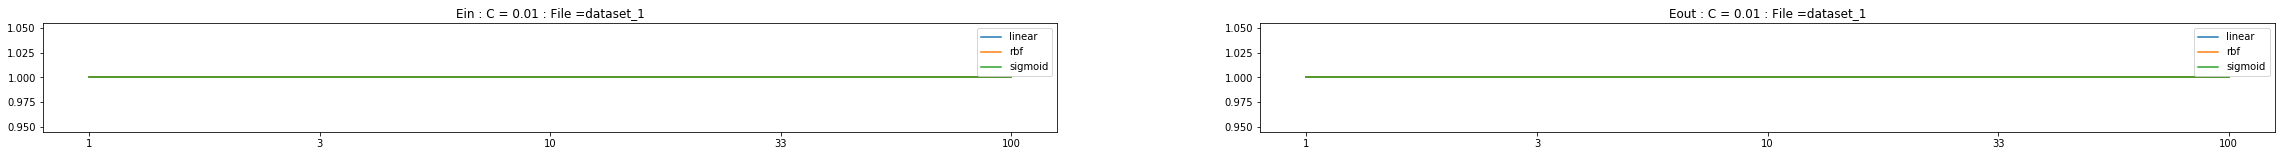

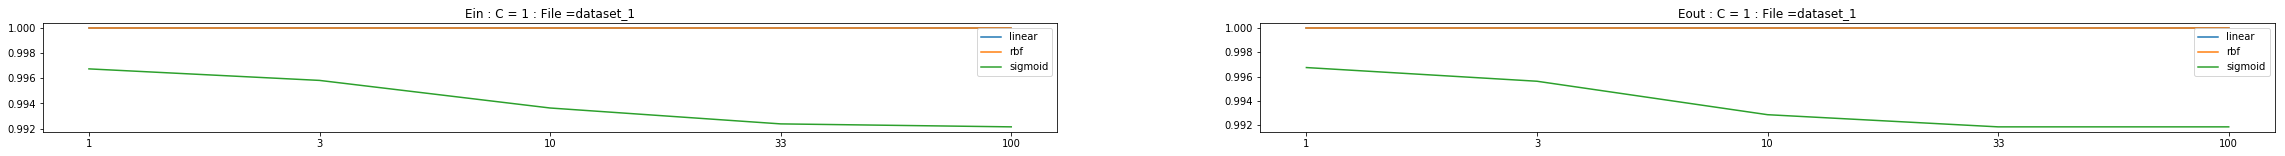

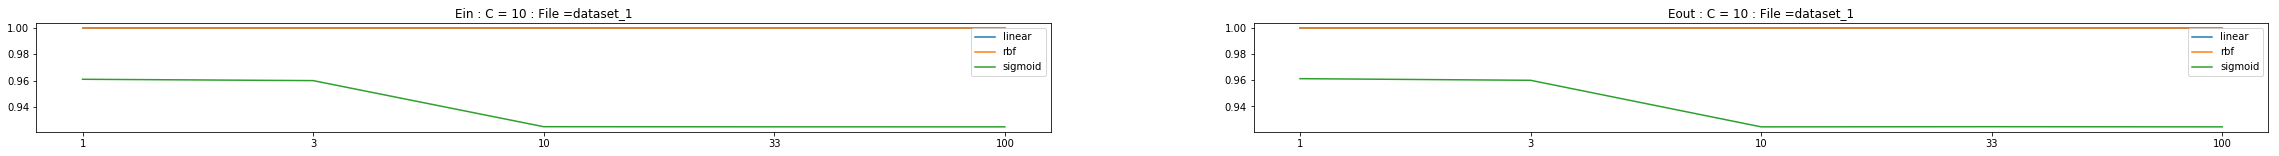

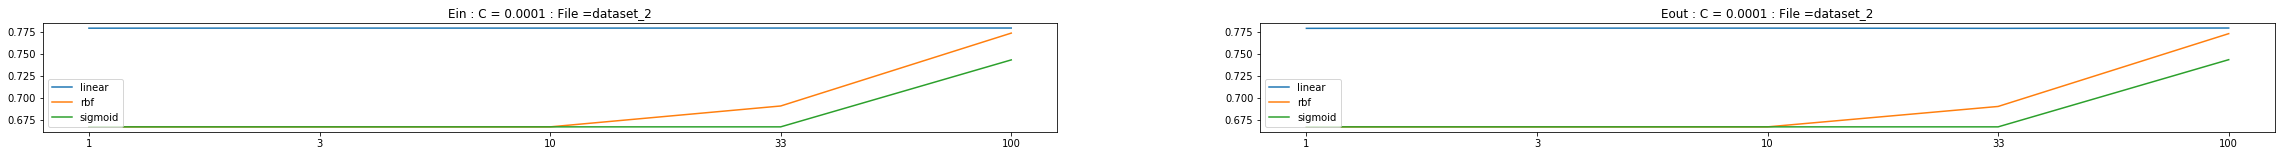

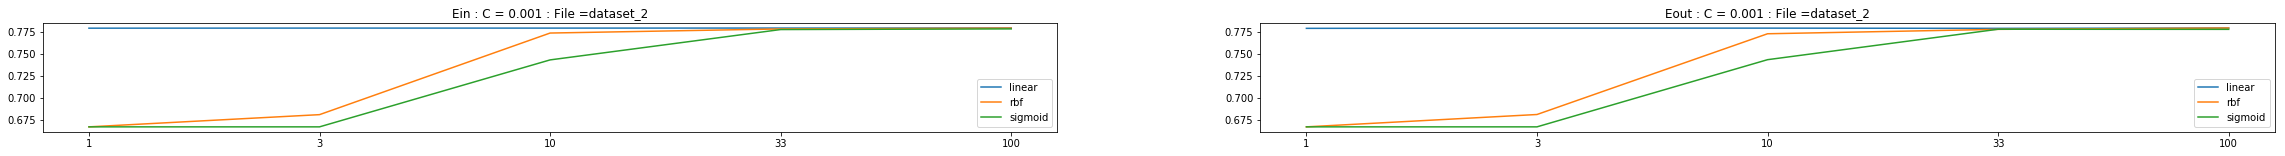

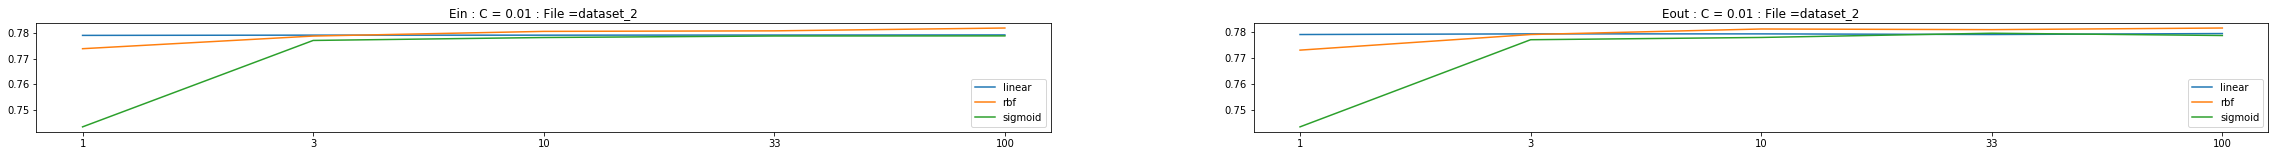

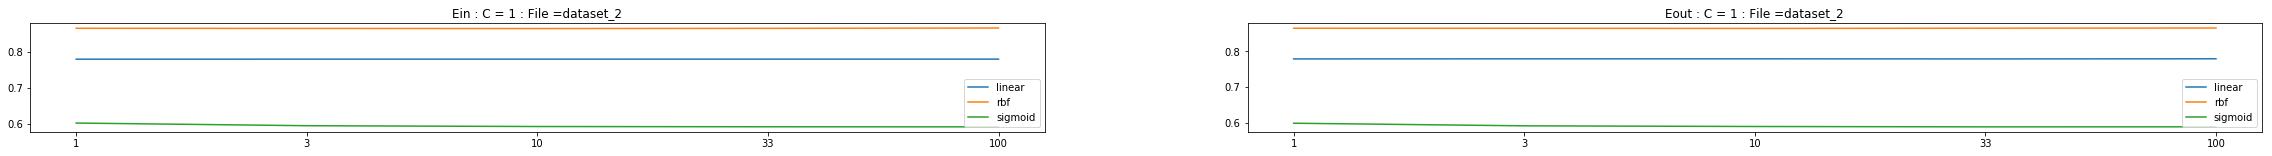

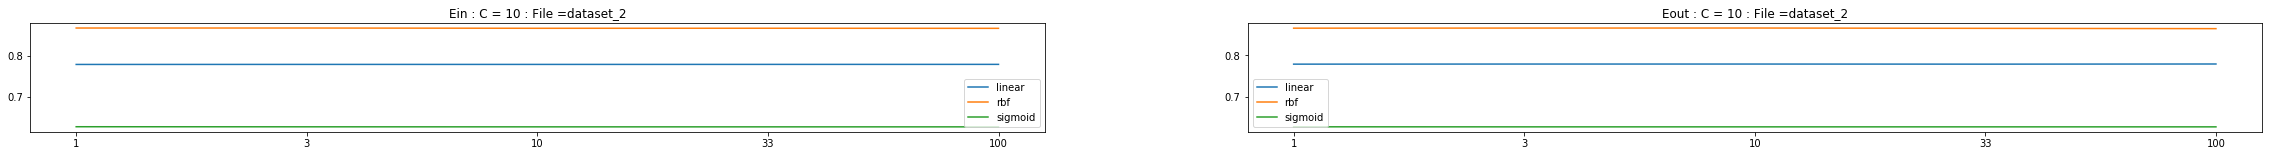

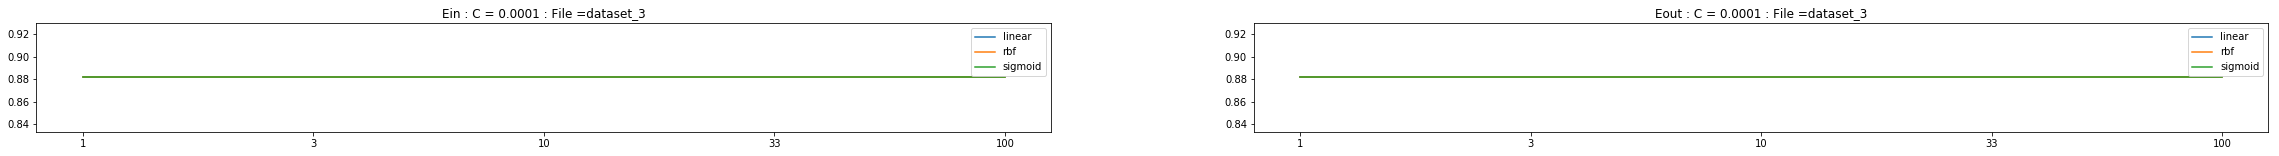

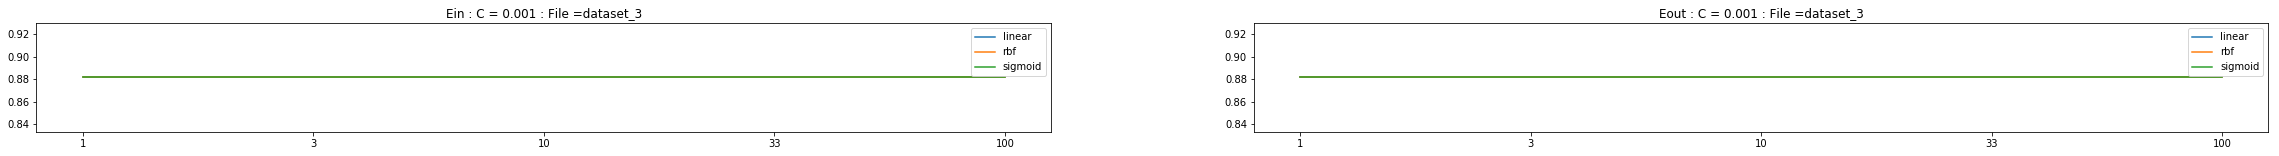

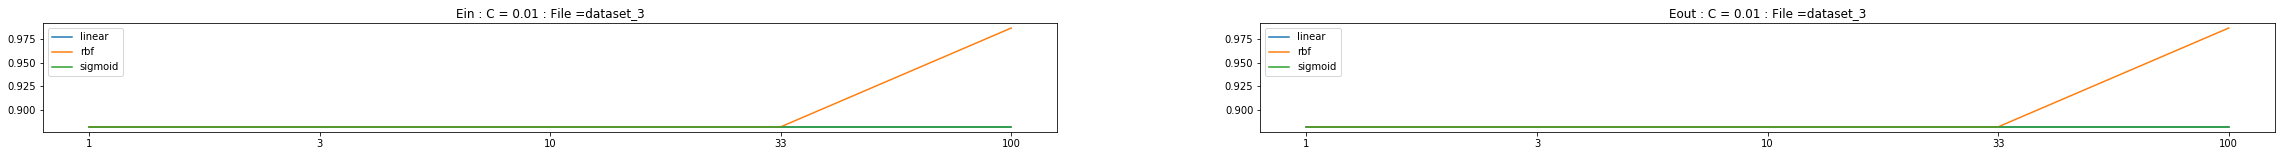

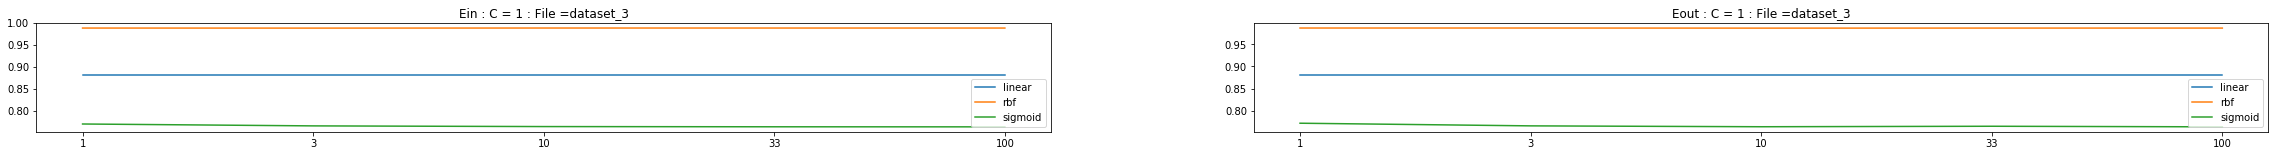

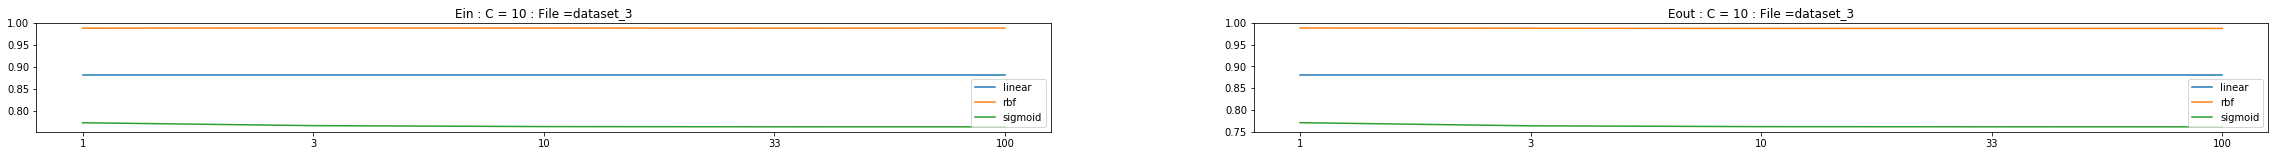

In [96]:
def plot_grid(res,file):
    i_s = np.unique(res[:,3])
    j_s = np.unique(res[:,4])

    for i in i_s:
        f = plt.figure(figsize=(40,2))
        for j in j_s:
            plt_data = res[(res[:,3] == i) & (res[:,4] == j)]
            ax = f.add_subplot(1,2,1)
            ax.plot(plt_data[:,2],plt_data[:,0].astype(float),label=j)
            ax.legend()
            ax.set_title("Ein : C = "+i+" : File ="+file)
            ax = f.add_subplot(1,2,2)
            ax.plot(plt_data[:,2],plt_data[:,1].astype(float),label=j)
            ax.legend()
            ax.set_title("Eout : C = "+i+" : File ="+file)
        f.show()

for i in [1,2,3]:
    results = GS_results[i-1]
    ein = results['mean_train_score']
    eout = results['mean_test_score']
    np_values = np.c_[ein,eout,np.array([list(p.values()) for p in results['params']])]
    plot_grid(np_values,"dataset_"+str(i))